```
MIT License

Copyright (c) 2020 Edward D. Lee, Bryan C. Daniels

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

# Usage guide to Convenient Interface to Inverse Ising 
This notebook gives examples of how to use the various algorithms included in ConIII for solving the inverse Ising problem. 

In this problem, the goal is to match the average orientation of each spin (the magnetization) $\{\langle s_{\rm i}\rangle\}$ and the pairwise correlations $\{\langle s_{\rm i} s_{\rm j}\rangle\}$ by finding the fields $\{h_{\rm i}\}$ and couplings $\{J_{\rm ij}\}$. This problem is explained in further detail in the accompanying [paper](https://doi.org/10.5334/jors.217).

## Overview of contents
Each algorithm for solving the inverse Ising problem is contained in a class contained in the `coniii.solvers` module. More architectural details are included in the accompanying paper.

To use an algorithm, an instance of the class must be declared and the `solve()` method called.[<sup>1</sup>](#fn1 "1")

This notebook starts by defining an $n=5$ model, which is solved in various ways. There are 15 parameters to find.[<sup>2</sup>](#fn2 "2") At the end of the notebook, we show how one can extend the package to handle higher order interactions (triplet interactions) with the MPF and MCH algorithms.

Throughout the code, "observables" refers to the constraints that are imposed in the model, and these must be calculated from some sample of states. The term "multipliers" refers to Langrangian multipliers (or parameters) that are found such that the constraints are met.

Feel free to open an issue on our GitHub page if you have any questions, comments, or feature requests. We welcome feedback!


#### Footnotes  
<sup>1</sup><span id="fn1">For some problems, you will also need to pass some helper functions that the algorithm needs. For the case of the pairwise maxent model, these helper functions are already part of the package. The details for writing the particular methods you may need for your problem can be found in the references cited in the [paper](https://doi.org/10.5334/jors.217).</span>  
<sup>2</sup><span id="fn2">Five parameters are the mean fields $h_{\rm i}$ corresponding to the mean orientation (magnetization) of the spins and ten parameters are for the pairwise couplings $J_{\rm ij}$ corresponding to the pairwise correlations.</span>

In [1]:
# Setup iPython environment.
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font',size=20)

# Setup
This section sets up an $n=5$ Ising problem to test. 

We define the model by choosing some random fields and couplings and sampling from the resulting distribution. This serves as an example problem where the true correlations and parameters are known and gives us a sense of how the different algorithms work on the inverse problem.

In [3]:
# Import common libraries.
from coniii import *
# Import file containing full equations for solving the n=5 system.
from coniii.ising_eqn import ising_eqn_5_sym

# Generate example data set.
n = 5  # system size
np.random.seed(0)  # standardize random seed
h = np.random.normal(scale=.1, size=n)           # random couplings
J = np.random.normal(scale=.1, size=n*(n-1)//2)  # random fields
hJ = np.concatenate((h, J))
p = ising_eqn_5_sym.p(hJ)  # probability distribution of all states p(s)
sisjTrue = ising_eqn_5_sym.calc_observables(hJ)  # exact means and pairwise correlations

allstates = bin_states(n, True)  # all 2^n possible binary states in {-1,1} basis
sample = allstates[np.random.choice(range(2**n),
                                    size=1000,
                                    replace=True,
                                    p=p)]  # random sample from p(s)
sisj = pair_corr(sample, concat=True)  # means and pairwise correlations

# Define useful functions for measuring success fitting procedure.
def error_on_correlations(estSisj):
    return np.linalg.norm( sisj - estSisj )

def error_on_multipliers(estMultipliers):
    return np.linalg.norm( hJ - estMultipliers )

def summarize(solver):
    print("Error on sample corr: %E"%error_on_correlations(solver.model.calc_observables(solver.multipliers)))
    print("Error on multipliers: %E"%error_on_multipliers(solver.multipliers))

# Enumeration
The Enumerate class implements the most direct approach to solving the inverse Ising problem by writing out all the constraint equations. This involves enumerating all the terms in the partition function $Z$.
<br><br>
#### Customizing the Enumerate class
Customizing the Enumerate class consists of a few steps.
1. Use `enumerate.py` helper module to write the equations corresponding to the system of interest. All pairwise Ising systems from sizes $n=2$ up to $n=9$ are already included in the `coniii.ising_eqn` module. But as an example, we can write the equations for the $n=5$ Ising model that we use in this notebook. First, you navigate to the installation directory in the site-package directory (this can be found by running `import coniii` and then `coniii.__path__`). Then, run in the terminal,<br><br>
`python enumerate.py 5 1`<br>  
The first argument to `enumerate.py` is the system size and the 1 indicates that the equations should be written for the symmetric Ising model $\sigma_{\rm i}\in\{-1,1\}$. For $\sigma_{\rm i}\in \{0,1\}$, we would put a 0 instead. The naming convention is "ising_eqn_[n][\_sym].py" where n is the system size and "\_sym" is the suffix if the spins are symmetric. Some more details are in the __main__ block at the bottom of `enumerate.py`. Note that file size grows exponentially with the size of the system!


3. Define the function for calculating the observables (usually the mean of each spin and pairwise correlations) using the parameters (Langrangian multipliers). This will be passed into the keyword argument `calc_observables_multipliers` when initializing an instance of Enumerate.<br><br>
2. Use the method Enumerate.solve to solve the problem.
<br>

#### Addenda (added April 2019)
- High precision versions of the Ising model equations using the mpmath module are possible with the `-hp=true` keyword argument.
- The `enumerate_potts.py` module provides limited support for Potts models. At the moment, functionality for writing the $k$-Potts model with $k$-dimensional field terms but only couplings for the average correlation across all $k$ dimensions is supported.

In [4]:
# Declare and call solver.
solver = Enumerate(sample)
solver.solve()
summarize(solver)

/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:118: UserWarning: Assuming that calc_observables should be for Ising model.
  warn("Assuming that calc_observables should be for Ising model.")


Error on sample corr: 5.173346E-16
Error on multipliers: 1.209459E-01


/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/enumerate.py:549: RuntimeWarning: divide by zero encountered in log
  return np.log(y)+Xmx, 1.


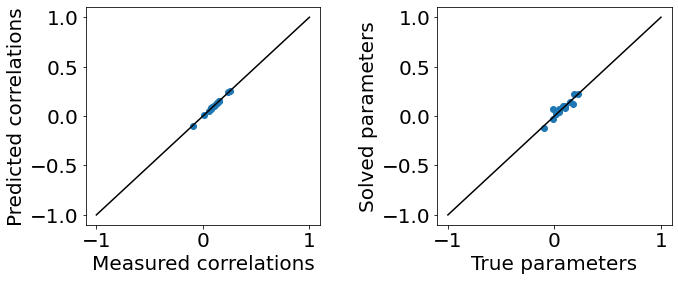

In [5]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, solver.model.calc_observables(solver.multipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, solver.multipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Minimum probability flow (MPF)
MPF involves minimizing a much simpler objective function. One component that is necessary is the connectivity matrix defining which states are connected to each other such that probability can flow between them. This is defined in the `adj()` function defined in the `utils.py` module for the Ising model.

MPF is easily generalizable to arbitrary constraints by defining the keyword argument `calc_observables`.

MPF is not expected to return the exact solution, but usually the estimated parameters are quite close to the ones calculated using MCH (shown below) while running faster. Note that MPF is given a finite sample from the true distribution to solve for, so we do not expect that it recover the same parameters, but it matches the correlations quite closely as measured with MCMC (Monte Carlo Markov chain) sampling.

In [6]:
# Declare and call solver.
solver = MPF(sample)
solver.solve()
summarize(solver)

/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:118: UserWarning: Assuming that calc_observables should be for Ising model.
  warn("Assuming that calc_observables should be for Ising model.")


Error on sample corr: 1.784730E-03
Error on multipliers: 1.215985E-01


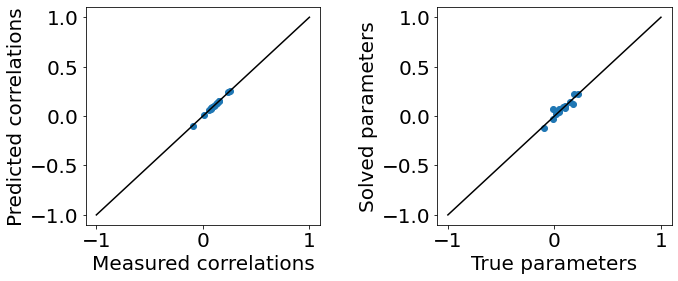

In [7]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, solver.model.calc_observables(solver.multipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, solver.multipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Pseudolikelihood
Pseudollikelihood requires calculating the conditional probability for a single spin given the rest of the system  
>$p_{\rm r}=\left.p(\sigma_{\rm r}\right|\sigma\backslash\sigma_{\rm r})$.

As a result, there is no guarantee that pseudolikelihood comes close to the solution, but it usually does quite well as shown below.

The Pseudo class is written specifically for the pairwise Ising model. 

If you wish to modify this, it requires that the user define a function `get_multipliers_r()` that retrieves the parameters from the parameters vector relevant for calculating $p_{\rm r}$ and `calc_observables_r()` that calculates $p_{\rm r}$ from a sample of states. Template functions that work for the Ising model are defined in `utils.define_pseudo_ising_helpers`.<br><br>

## Notes
- The coupling matrix is constrained to be symmetric in the code below $J_{\rm ij}=J_{\rm ji}$.

In [8]:
solver = Pseudo(sample)
solver.solve()
summarize(solver)

/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:118: UserWarning: Assuming that calc_observables should be for Ising model.
  warn("Assuming that calc_observables should be for Ising model.")


Error on sample corr: 1.866256E-04
Error on multipliers: 1.209458E-01


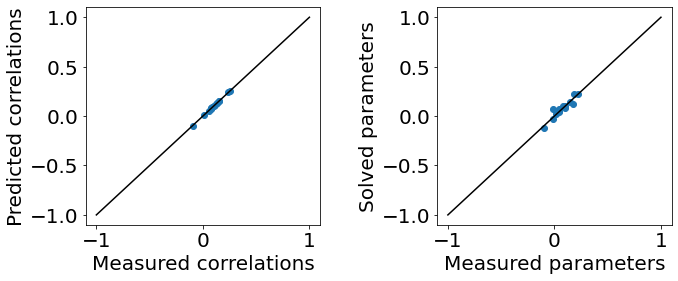

In [9]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj, solver.model.calc_observables(solver.multipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, solver.multipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='Measured parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Adaptive cluster expansion
Cluster expansion can be made to get arbitrarily close to matching the measured correlations exactly but at the cost of increased run time.

Cluster expansion is written specifically for the pairwise Ising model. The user must specify a threshold that determines when the algorithm stops. A lower threshold will return a more accurate answer, but will also take longer to run.

In [10]:
solver = ClusterExpansion(sample, rng=np.random.RandomState(0))

threshold = 0.001
solver.solve(threshold)
summarize(solver)

/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:118: UserWarning: Assuming that calc_observables should be for Ising model.
  warn("Assuming that calc_observables should be for Ising model.")


adaptiveClusterExpansion: Clusters of size 2
adaptiveClusterExpansion: Clusters of size 3
Error on sample corr: 4.341187E-02
Error on multipliers: 1.221601E-01


/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/samplers.py:1185: UserWarning: Assuming that the model is Ising.
  if iprint: warn("Assuming that the model is Ising.")


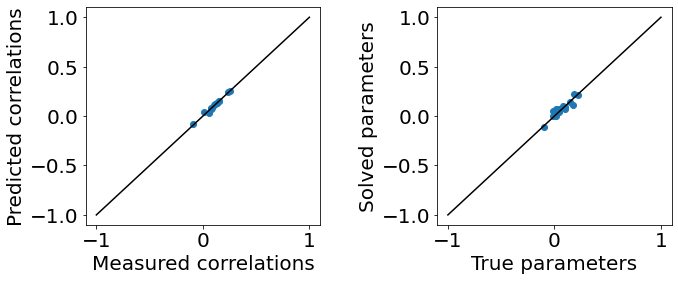

In [11]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, solver.model.calc_observables(solver.multipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, solver.multipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Monte Carlo histogram (MCH)
MCH is easily generalizable to any maxent problem.

MCH loops a sampling step for approximating the distribution with the current set of multipliers and then a run of the MCH approximation step on that sample. This method is the slow because of the time required for sampling from  $p(\sigma)$ and requires fine tuning to adjust the learning rule. The algorithm can get arbitrarily close to matching the measured correlations, but at the expense of runtime as specified in the accompanying paper.

The user must define how to perform the MCH approximation step for the problem at hand. The Ising model is already implemented in mchApproximation. The user must specify parameters for the sampling routine and the learning rule.
These can be modified during the run by passing in a function for the keyword `custom_convergence_f()`.

The size of the sample will determine how accurately the algorithm can converge to the answer. Roughly speaking, you can expect your sampling error for each estimated correlation to scale as $1/\sqrt{K}$ where $K$ is your sample size.

In [12]:
# Setting n_cpus=1 turns of parallelization with the multiprocess module 
# which can be faster because of overhead associated with initializing 
# multiple threads.
solver = MCH(sample,
             sample_size=100,
             rng=np.random.RandomState(0),
             n_cpus=1)

# Define function for changing learning parameters as we converge.
def learn_settings(i):
    """
    Take in the iteration counter and set the maximum change allowed in any given 
    parameter (maxdlamda) and the multiplicative factor eta, where 
    d(parameter) = (error in observable) * eta.
    
    Additional option is to also return the sample size for that step by returning a 
    tuple. Larger sample sizes are necessary for higher accuracy.
    """
    return {'maxdlamda':exp(-i/5.),'eta':exp(-i/5.)}

# Run solver.
solver.solve(maxiter=40,
             custom_convergence_f=learn_settings)
summarize(solver)

/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:749: UserWarning: Small sample size will lead to poor convergence.
  if sample_size < 1000: warn("Small sample size will lead to poor convergence.")
/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:118: UserWarning: Assuming that calc_observables should be for Ising model.
  warn("Assuming that calc_observables should be for Ising model.")


Error on sample corr: 3.340644E+00
Error on multipliers: 4.780901E+00


/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/samplers.py:1185: UserWarning: Assuming that the model is Ising.
  if iprint: warn("Assuming that the model is Ising.")
/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:830: UserWarning: Number of burn in MCMC iterations between samples may be too small for convergence to stationary distribution.
  warn("Number of burn in MCMC iterations between samples may be too small for "+
/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:833: UserWarning: Number of MCMC iterations between samples may be too small for convergence to stationary distribution.
  warn("Number of MCMC iterations between samples may be too small for convergence to "+


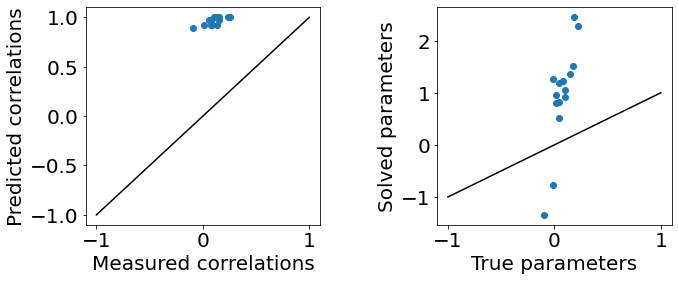

In [13]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, solver.model.calc_observables(solver.multipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, solver.multipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Regularized mean field
RMF is specific to the pairwise Ising model.

RMF is an analytic mean-field approximation in which the magnitude of couplings are regularized.  The strength of the regularization $\gamma$ is found by maximum likelihood as estimated from MC sampling. Thus, we typically expect this approach to do match the correlations worse when the regularization is stronger as can be seen below.

In [14]:
# This takes a while!
solver = RegularizedMeanField(sample,
                              rng=np.random.RandomState(0),
                              sample_size=100,
                              n_cpus=1)
solver.solve()
summarize(solver)

/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:2522: UserWarning: Small sample size will lead to poor convergence.
  if sample_size<1000: warn("Small sample size will lead to poor convergence.")
/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:118: UserWarning: Assuming that calc_observables should be for Ising model.
  warn("Assuming that calc_observables should be for Ising model.")


coocSampleCovariance : WARNING : using ad-hoc 'Laplace' correction
Error on sample corr: 7.092762E-01
Error on multipliers: 5.318007E-01


/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/samplers.py:1185: UserWarning: Assuming that the model is Ising.
  if iprint: warn("Assuming that the model is Ising.")


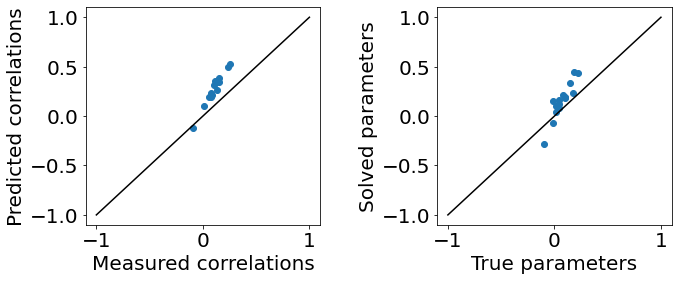

In [15]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, solver.model.calc_observables(solver.multipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, solver.multipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Triplet interaction model

The pairwise Ising model can be extended to include interactions between triplets of spins denoted by $K_{\rm ijk}$  
$\displaystyle E(\{s_{\rm i}\}) = -\sum_{\rm i<j<k} K_{\rm ijk} s_{\rm i} s_{\rm j} s_{\rm k} -\sum_{\rm i<j}J_{\rm ij}s_{\rm i}s_{\rm j} -\sum_{\rm i}^Nh_{\rm i}$

In [16]:
from coniii.ising_eqn import ising_eqn_5_sym_triplet as ising
from coniii.models import Triplet
# must change default calc_observables function to handle triplets
calc_observables = define_triplet_helper_functions()[1]

# Generate example data set.
np.random.seed(1)  # standardize random seed
h = np.random.normal(scale=.1, size=n)  # random fields
J = np.random.normal(scale=.1, size=n*(n-1)//2)  # couplings
K = np.random.normal(scale=.05, size=n*(n-1)*(n-2)//6)  # triplet interactions
hJK = np.concatenate((h, J, K))
p = ising.p(hJK)  # probability distribution of all states p(s)
sisjTrue = ising.calc_observables(hJK)  # exact means and pairwise correlations

allstates = bin_states(n, True)  # all 2^n possible binary states in {-1,1} basis
sample = allstates[np.random.choice(range(2**n),
                                    size=1000,
                                    replace=True,
                                    p=p)]  # random sample from p(s)
sisj = calc_observables(sample).mean(0)  # means and pairwise correlations

# Define useful functions for measuring success fitting procedure.
def error_on_correlations(estSisj):
    return np.linalg.norm( sisj - estSisj )

def error_on_multipliers(estMultipliers):
    return np.linalg.norm( hJK - estMultipliers )

def summarize(solver):
    print("Error on sample corr: %E"%error_on_correlations(solver.model.calc_observables(solver.multipliers)))
    print("Error on multipliers: %E"%error_on_multipliers(solver.multipliers))

# MPF (triplets)
We give an example of Minimum Probability Flow (MPF) extended to this triplet interaction model.

In [17]:
# Declare and call solver.
solver = MPF(sample,
             model=Triplet([np.zeros(n), np.zeros(int(binom(n,2))), np.zeros(int(binom(n,3)))]),
             calc_observables=calc_observables)
solver.solve()
summarize(solver)

Error on sample corr: 3.701306E-03
Error on multipliers: 2.017199E-01


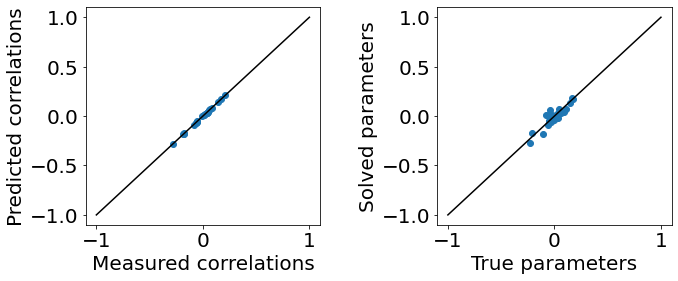

In [18]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, ising.calc_observables(solver.multipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJK, solver.multipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# MCH (triplets)
We give an example of Monte Carlo Histogram (MCH) extended to this triplet interaction model.

In [19]:
# Redefine mch_approximation to handle triplet interactions. This involves 
# changing lines 5 and 7 to account for the triplet interactions and 
# correlations.
def mch_approximation( samples, dlamda ):
        """Function for making MCH approximation step for Ising model."""
        dE = calc_observables(samples).dot(dlamda)
        ZFraction = len(dE) / np.exp(logsumexp(-dE))
        predsisj = ( calc_observables( samples )*np.exp(-dE)[:,None] ).mean(0) * ZFraction  
        assert not (np.any(predsisj<-1.00000001) or
            np.any(predsisj>1.000000001)),"Predicted values are beyond limits, (%1.6f,%1.6f)"%(predsisj.min(),
                                                                                               predsisj.max())
        return predsisj

# Define function for changing learning parameters as we converge.
def learn_settings(i):
    """
    Take in the iteration counter and set the maximum change allowed in any given 
    parameter (maxdlamda) and the multiplicative factor eta, where 
    d(parameter) = (error in observable) * eta.
    
    Additional option is to also return the sample size for that step by returning a 
    tuple. Larger sample sizes are necessary for higher accuracy.
    """
    return {'maxdlamda':exp(-i/5.),'eta':exp(-i/5.)}

# Initialize solver.
solver = MCH(sample,
             model=Triplet([np.zeros(n), np.zeros(int(binom(n,2))), np.zeros(int(binom(n,3)))],
                           rng=np.random.RandomState(0),
                           n_cpus=1),
             calc_observables=calc_observables,
             sample_size=100,
             mch_approximation=mch_approximation)

# Run solver.
solver.solve(maxiter=50,
             burn_in=100,
             n_iters=30,
             custom_convergence_f=learn_settings)
summarize(solver)

/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:749: UserWarning: Small sample size will lead to poor convergence.
  if sample_size < 1000: warn("Small sample size will lead to poor convergence.")
/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/samplers.py:1193: UserWarning: Boost C++ implementation not available. Defaulting to slower sampling methods.
  warn("Boost C++ implementation not available. Defaulting to slower sampling methods.")
/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:833: UserWarning: Number of MCMC iterations between samples may be too small for convergence to stationary distribution.
  warn("Number of MCMC iterations between samples may be too small for convergence to "+


Error on sample corr: 9.192702E-02
Error on multipliers: 3.051864E-01


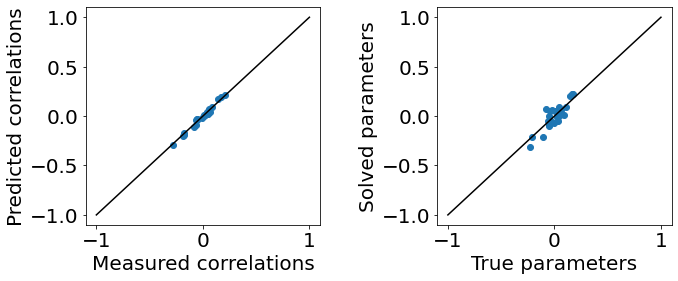

In [20]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, ising.calc_observables(solver.multipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJK, solver.multipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Potts model
This is a more detailed example for solving the k-state Potts model using pseudolikelihood then refining the answer with MC histogram.

In [21]:
from coniii.models import Potts3
from coniii.utils import define_pseudo_potts_helper_functions, define_potts_helper_functions
import coniii.samplers as mc

np.random.seed(0)  # standardize random seed

In [22]:
# set up problem
n = 5  # system size
k = 3  # number of possible configurations
h = np.random.normal(size=n*k, scale=.1)
h[(k-1)*n:] = 0.  # zero out last set of fields
J = np.random.normal(size=n*(n-1)//2, scale=1/n)

# declare some helper functions
calc_e, calc_observables, mch_approximation = define_potts_helper_functions(k)
get_multipliers_r, calc_observables_r = define_pseudo_potts_helper_functions(n, k)

# sample from given Potts model
sampler = mc.Potts3(n, np.concatenate([h,J]), calc_e=calc_e)
sampler.generate_samples_parallel(1000, n_iters=500, burn_in=1000)
X = sampler.samples

# solve the inverse problem
solver = Pseudo(X,
                calc_observables_r=calc_observables_r,
                get_multipliers_r=get_multipliers_r,
                model=Potts3([h,J]),
                calc_observables=calc_observables,
                k=k)
solver.solve();

# Create model to hold results and generate MC sample
model = Potts3(solver.multipliers)
model.setup_sampler()
model.generate_samples(500, 1_000)

/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:104: UserWarning: Data is not only -1, 1 entries.
  warn("Data is not only -1, 1 entries.")


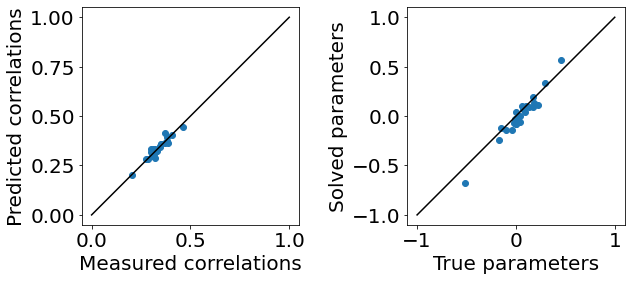

In [23]:
# Take a look at Pseudo approximation to solution
fig, ax = plt.subplots(subplot_kw={'aspect':'equal'}, ncols=2, figsize=(10,4))
ax[0].plot(calc_observables(X).mean(0), calc_observables(model.sample).mean(0), 'o')
ax[0].plot([0,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(np.concatenate([h,J]), solver.multipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.4)

In [24]:
# Use MCH to refine solution
# If Boost library is properly installed, then this should take about 1 second.
solver = MCH(X,
             sample_size=10_000,
             rng=np.random.RandomState(0),
             calc_observables=calc_observables,
             model=model,
             mch_approximation=mch_approximation)

# Define function for changing learning parameters as we converge.
def learn_settings(i):
    """
    Take in the iteration counter and set the maximum change allowed in any given 
    parameter (maxdlamda) and the multiplicative factor eta, where 
    d(parameter) = (error in observable) * eta.
    
    Additional option is to also return the sample size for that step by returning a 
    tuple. Larger sample sizes are necessary for higher accuracy.
    """
    return {'maxdlamda':exp(-i/5.)*.5,'eta':exp(-i/5.)*.5}

# Run solver.
solver.solve(initial_guess=model.multipliers,
             maxiter=30,
             custom_convergence_f=learn_settings,
             n_iters=500,
             burn_in=1_000);

/home/eddie/anaconda3/envs/coniii/lib/python3.8/site-packages/coniii/solvers.py:104: UserWarning: Data is not only -1, 1 entries.
  warn("Data is not only -1, 1 entries.")


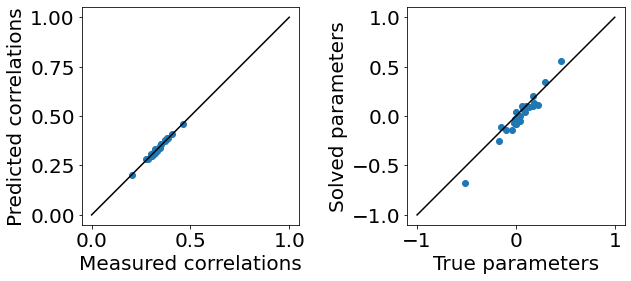

In [25]:
fig, ax = plt.subplots(subplot_kw={'aspect':'equal'}, ncols=2, figsize=(10,4))
ax[0].plot(calc_observables(X).mean(0), calc_observables(model.sample).mean(0), 'o')
ax[0].plot([0,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(np.concatenate([h,J]), solver.multipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.4)